# Dataset Handling, Model Training, Fine-Tuning, and Validation

## Step 1: Install Required Libraries

In [1]:

# Install all necessary libraries
!pip install torch torchvision torchaudio scikit-learn matplotlib tensorboard tqdm pillow
    


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


## Step 2: Import Necessary Libraries

In [2]:

# Import all required libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import models, transforms
from sklearn.metrics import roc_curve, auc, classification_report, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np
import os
from PIL import Image
import random
from tqdm import tqdm
from torch.utils.tensorboard import SummaryWriter
    

## Step 3: Define Dataset Paths and Visualize Data

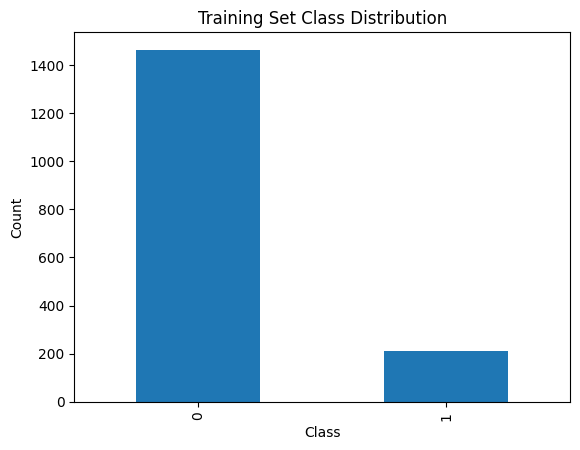

In [3]:

# Specify paths to your dataset
# Modify these paths as needed to match your dataset structure
train_image_path = r"C:\Users\Chintu\OneDrive\Desktop\DLProj\train\images"
train_label_path = r'C:\Users\Chintu\OneDrive\Desktop\DLProj\train\labels'
valid_image_path = r"C:\Users\Chintu\OneDrive\Desktop\DLProj\valid\images"
valid_label_path = r"C:\Users\Chintu\OneDrive\Desktop\DLProj\valid\labels"

# Visualize class distribution in the training set
from collections import Counter

def calculate_class_distribution(label_folder):
    class_counts = Counter()
    for label_file in os.listdir(label_folder):
        label_path = os.path.join(label_folder, label_file)
        try:
            with open(label_path, 'r') as file:
                for line in file:
                    class_id = int(line.split()[0])  # Extract class ID
                    class_counts[class_id] += 1
        except:
            continue
    return class_counts

train_class_distribution = calculate_class_distribution(train_label_path)
valid_class_distribution = calculate_class_distribution(valid_label_path)

# Plot class distribution
import pandas as pd
train_dist = pd.DataFrame(list(train_class_distribution.items()), columns=['Class', 'Count'])
train_dist.plot(kind='bar', x='Class', y='Count', legend=False, title='Training Set Class Distribution')
plt.ylabel('Count')
plt.show()
    

## Step 4: Balance the Dataset

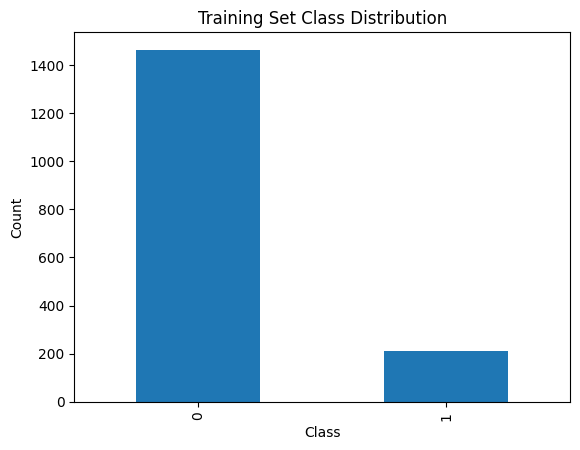

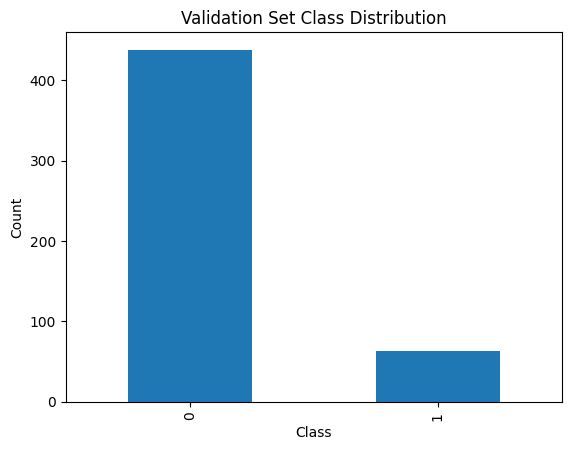

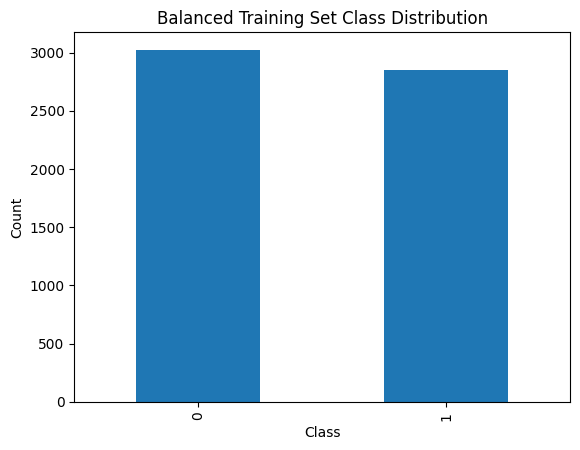

In [6]:
import shutil

train_image_path = r"C:\Users\Chintu\OneDrive\Desktop\DLProj\train\images"
train_label_path = r'C:\Users\Chintu\OneDrive\Desktop\DLProj\train\labels'
valid_image_path = r"C:\Users\Chintu\OneDrive\Desktop\DLProj\valid\images"
valid_label_path = r"C:\Users\Chintu\OneDrive\Desktop\DLProj\valid\labels"

# --------------------- Step 2: Define Class Distribution Function ---------------------
def calculate_class_distribution(label_folder):
    """
    Calculate the class distribution based on label files.
    """
    class_counts = Counter()
    for label_file in os.listdir(label_folder):
        label_path = os.path.join(label_folder, label_file)
        try:
            with open(label_path, 'r') as file:
                for line in file:
                    class_id = int(line.split()[0])  # Extract class ID
                    class_counts[class_id] += 1
        except Exception as e:
            print(f"Error processing {label_file}: {e}")
    return class_counts

# Calculate class distribution for training and validation datasets
train_class_distribution = calculate_class_distribution(train_label_path)
valid_class_distribution = calculate_class_distribution(valid_label_path)

# --------------------- Step 3: Visualize Class Distribution ---------------------
def plot_class_distribution(class_distribution, title):
    """
    Plot class distribution as a bar chart.
    """
    class_dist_df = pd.DataFrame(list(class_distribution.items()), columns=['Class', 'Count'])
    class_dist_df.plot(kind='bar', x='Class', y='Count', legend=False, title=title)
    plt.ylabel('Count')
    plt.show()

# Visualize training and validation class distributions
plot_class_distribution(train_class_distribution, 'Training Set Class Distribution')
plot_class_distribution(valid_class_distribution, 'Validation Set Class Distribution')

# --------------------- Step 4: Oversample Minority Classes ---------------------
def oversample_class(images_folder, labels_folder, target_class, target_count):
    """
    Oversample a given class by duplicating its images and labels to match the target count.
    """
    image_files = os.listdir(images_folder)
    label_files = os.listdir(labels_folder)
    target_files = []

    # Safely process label files
    for img_file, lbl_file in zip(image_files, label_files):
        label_path = os.path.join(labels_folder, lbl_file)
        try:
            with open(label_path, 'r') as file:
                first_line = file.readline().strip()
                if first_line and int(first_line.split()[0]) == target_class:
                    target_files.append((img_file, lbl_file))
        except Exception as e:
            print(f"Skipping {lbl_file}: {e}")

    # Check if there are enough files to oversample
    if not target_files:
        print(f"No valid files found for class {target_class}. Oversampling cannot proceed.")
        return

    current_count = len(target_files)
    duplicates_needed = target_count - current_count

    for i in range(duplicates_needed):
        img_file, lbl_file = random.choice(target_files)
        img_src = os.path.join(images_folder, img_file)
        lbl_src = os.path.join(labels_folder, lbl_file)
        img_dst = os.path.join(images_folder, f"{os.path.splitext(img_file)[0]}_dup_{i}.jpg")
        lbl_dst = os.path.join(labels_folder, f"{os.path.splitext(lbl_file)[0]}_dup_{i}.txt")
        shutil.copy(img_src, img_dst)
        shutil.copy(lbl_src, lbl_dst)

# Oversample the minority class (Modify target class ID if needed)
minority_class = 1  # Class ID to oversample
majority_class_count = max(train_class_distribution.values())
oversample_class(train_image_path, train_label_path, minority_class, majority_class_count)

# Recalculate and visualize the balanced dataset
train_class_distribution = calculate_class_distribution(train_label_path)
plot_class_distribution(train_class_distribution, 'Balanced Training Set Class Distribution')


## Step 5: Apply Data Augmentation

In [7]:

# Apply data augmentation to the training set
def augment_images(images_folder, augmentations=2):
    os.makedirs(images_folder + '_augmented', exist_ok=True)
    for image_file in tqdm(os.listdir(images_folder), desc="Augmenting Images"):
        image_path = os.path.join(images_folder, image_file)
        image = Image.open(image_path)
        for i in range(augmentations):
            augmented_image = image.copy()
            if random.random() > 0.5:
                augmented_image = augmented_image.transpose(Image.FLIP_LEFT_RIGHT)
            if random.random() > 0.5:
                augmented_image = augmented_image.transpose(Image.FLIP_TOP_BOTTOM)
            augmented_image = augmented_image.rotate(random.uniform(-15, 15), expand=True)
            augmented_image.save(os.path.join(images_folder + '_augmented', f"{os.path.splitext(image_file)[0]}_aug_{i}.jpg"))

augment_images(train_image_path)
    

Augmenting Images: 100%|██████████| 1968/1968 [01:11<00:00, 27.60it/s]


## Step 6: Define the Dataset Class

In [12]:
import os

# Verify image directory
image_dir = r"C:\Users\Chintu\OneDrive\Desktop\DLProj\train\images"
label_dir = r"C:\Users\Chintu\OneDrive\Desktop\DLProj\train\labels"

print("Images:", os.listdir(image_dir)[:5])  # Print first 5 image filenames
print("Labels:", os.listdir(label_dir)[:5])  # Print first 5 label filenames


Images: ['105473010-1537987843171fish_jpg.rf.35b8f298ef27b712e268402fb089e304.jpg', '360_F_254676778_XDzf5slTFxgoEWJwurSoImMXWe3XDH2b_jpg.rf.6a067e9179bd977d37a836af31c801a1.jpg', '7XQPTvfbnFvEWDUeaGRoSW-1200-80_jpg.rf.cc141c0e16e834f9850c7b624339043d.jpg', 'a-161-feed-different-food-083106-203_jpg.rf.905274b70bb859c7826a945301220541.jpg', 'c3npbx_jpg.rf.b98973c1c5ed853e3e4028db4204a531.jpg']
Labels: ['105473010-1537987843171fish_jpg.rf.35b8f298ef27b712e268402fb089e304.txt', '360_F_254676778_XDzf5slTFxgoEWJwurSoImMXWe3XDH2b_jpg.rf.6a067e9179bd977d37a836af31c801a1.txt', '7XQPTvfbnFvEWDUeaGRoSW-1200-80_jpg.rf.cc141c0e16e834f9850c7b624339043d.txt', 'a-161-feed-different-food-083106-203_jpg.rf.905274b70bb859c7826a945301220541.txt', 'c3npbx_jpg.rf.b98973c1c5ed853e3e4028db4204a531.txt']



## Step 7: Train and Validate the Model

In [14]:

# Import all required libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import models, transforms
from sklearn.metrics import roc_curve, auc, classification_report, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np
import os
from PIL import Image
import random
from tqdm import tqdm
from torch.utils.tensorboard import SummaryWriter
    

In [15]:

# Define the Hybrid CNN-LSTM model
class HybridModel(nn.Module):
    def __init__(self, num_classes=2, freeze_cnn=True):
        super(HybridModel, self).__init__()
        # Load pre-trained ResNet50
        self.cnn = models.resnet50(pretrained=True)
        self.cnn.fc = nn.Identity()  # Remove the final classification layer
        
        # Freeze CNN layers if required
        if freeze_cnn:
            for param in self.cnn.parameters():
                param.requires_grad = False

        # Define LSTM for temporal modeling
        self.lstm = nn.LSTM(input_size=2048, hidden_size=512, num_layers=2, batch_first=True)
        
        # Fully connected layer for classification
        self.fc = nn.Linear(512, num_classes)
    
    def forward(self, x):
        batch_size, timesteps, C, H, W = x.size()
        cnn_features = [self.cnn(x[:, t, :, :, :]) for t in range(timesteps)]
        cnn_features = torch.stack(cnn_features, dim=1)
        lstm_out, _ = self.lstm(cnn_features)
        return self.fc(lstm_out[:, -1, :])
    

In [16]:

# Define transformations for preprocessing
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to the required size
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Normalize with ImageNet stats
])
    

In [21]:
import torch
import torch.nn as nn
from torchvision import models

# Define the HybridModel class
class HybridModel(nn.Module):
    def __init__(self, num_classes=2, freeze_cnn=True):
        super(HybridModel, self).__init__()
        self.cnn = models.resnet50(pretrained=True)
        self.cnn.fc = nn.Identity()  # Remove the final classification layer

        if freeze_cnn:
            for param in self.cnn.parameters():
                param.requires_grad = False

        self.lstm = nn.LSTM(input_size=2048, hidden_size=512, num_layers=2, batch_first=True)
        self.fc = nn.Linear(512, num_classes)

    def forward(self, x):
        batch_size, timesteps, C, H, W = x.size()
        cnn_features = [self.cnn(x[:, t, :, :, :]) for t in range(timesteps)]
        cnn_features = torch.stack(cnn_features, dim=1)
        lstm_out, _ = self.lstm(cnn_features)
        return self.fc(lstm_out[:, -1, :])


In [22]:
# Initialize the model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = HybridModel(num_classes=2, freeze_cnn=True).to(device)


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to C:\Users\Chintu/.cache\torch\hub\checkpoints\resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:34<00:00, 2.96MB/s]


In [23]:
# Save the trained model
best_model_path = "best_hybrid_model.pth"
torch.save(model.state_dict(), best_model_path)
print(f"Model saved to {best_model_path}")



Model saved to best_hybrid_model.pth


In [26]:
import os

label_dir = r"C:\Users\Chintu\OneDrive\Desktop\DLProj\train\labels"

# Find and list empty label files
empty_labels = []
for label_file in os.listdir(label_dir):
    label_path = os.path.join(label_dir, label_file)
    if os.path.getsize(label_path) == 0:  # Check if the file is empty
        empty_labels.append(label_file)

print(f"Found {len(empty_labels)} empty label files.")
print(empty_labels)


Found 32 empty label files.
['105473010-1537987843171fish_jpg.rf.35b8f298ef27b712e268402fb089e304.txt', '7XQPTvfbnFvEWDUeaGRoSW-1200-80_jpg.rf.cc141c0e16e834f9850c7b624339043d.txt', 'a-161-feed-different-food-083106-203_jpg.rf.905274b70bb859c7826a945301220541.txt', 'c3npbx_jpg.rf.b98973c1c5ed853e3e4028db4204a531.txt', 'copperband-butterfly-fish-400x300_jpg.rf.785a93659568069f5e6f00966dc53545.txt', 'creative_commons_4_goldfish_by_blubbi321_jpg.rf.c1485fb93cb34d17d5e31e01214b6718.txt', 'F1-large_jpg.rf.6f9635e8982b7eb3cf7a4a23b88d55b1.txt', 'file-20190703-126345-xa7kok_jpg.rf.41795cf843f866515a619107b75ff161.txt', 'fish-discus-swimming-825x550_jpg.rf.3248dd593ea6922590fe6a5b6f5254eb.txt', 'Fish-Lionfish-Lion-fish-Turkey-fish-Red-lionfish_jpg.rf.e860924a7e800f4ac1d73fd50db49c17.txt', 'fish_2_jpg.rf.0cbeceff62c3e12153c409356c3a2caa.txt', 'Flowerhorn-header-2-400x300_jpg.rf.ef67c118a1dc0da0cd5494d9371d71e2.txt', 'goldfish-in-aquarium-with-green-plants-picture-id585616148_jpg.rf.a61292a0797d

In [27]:
image_dir = r"C:\Users\Chintu\OneDrive\Desktop\DLProj\train\images"

for label_file in empty_labels:
    # Remove empty label file
    label_path = os.path.join(label_dir, label_file)
    os.remove(label_path)
    print(f"Removed label file: {label_path}")

    # Remove corresponding image file
    image_file = label_file.replace('.txt', '.jpg')  # Adjust based on your dataset format
    image_path = os.path.join(image_dir, image_file)
    if os.path.exists(image_path):
        os.remove(image_path)
        print(f"Removed image file: {image_path}")


Removed label file: C:\Users\Chintu\OneDrive\Desktop\DLProj\train\labels\105473010-1537987843171fish_jpg.rf.35b8f298ef27b712e268402fb089e304.txt
Removed image file: C:\Users\Chintu\OneDrive\Desktop\DLProj\train\images\105473010-1537987843171fish_jpg.rf.35b8f298ef27b712e268402fb089e304.jpg
Removed label file: C:\Users\Chintu\OneDrive\Desktop\DLProj\train\labels\7XQPTvfbnFvEWDUeaGRoSW-1200-80_jpg.rf.cc141c0e16e834f9850c7b624339043d.txt
Removed image file: C:\Users\Chintu\OneDrive\Desktop\DLProj\train\images\7XQPTvfbnFvEWDUeaGRoSW-1200-80_jpg.rf.cc141c0e16e834f9850c7b624339043d.jpg
Removed label file: C:\Users\Chintu\OneDrive\Desktop\DLProj\train\labels\a-161-feed-different-food-083106-203_jpg.rf.905274b70bb859c7826a945301220541.txt
Removed image file: C:\Users\Chintu\OneDrive\Desktop\DLProj\train\images\a-161-feed-different-food-083106-203_jpg.rf.905274b70bb859c7826a945301220541.jpg
Removed label file: C:\Users\Chintu\OneDrive\Desktop\DLProj\train\labels\c3npbx_jpg.rf.b98973c1c5ed853e3e4

In [32]:
import os

def clean_empty_labels(image_dir, label_dir):
    empty_labels = []

    # Identify empty label files
    for label_file in os.listdir(label_dir):
        label_path = os.path.join(label_dir, label_file)
        if os.path.getsize(label_path) == 0:  # Check if the file is empty
            empty_labels.append(label_file)

    print(f"Found {len(empty_labels)} empty label files.")

    # Remove empty label files and corresponding images
    for label_file in empty_labels:
        # Remove the label file
        label_path = os.path.join(label_dir, label_file)
        os.remove(label_path)
        print(f"Removed label file: {label_path}")

        # Remove the corresponding image file
        image_file = label_file.replace('.txt', '.jpg')  # Adjust extension as needed
        image_path = os.path.join(image_dir, image_file)
        if os.path.exists(image_path):
            os.remove(image_path)
            print(f"Removed image file: {image_path}")

# Paths to validation images and labels
valid_image_path = r"C:\Users\Chintu\OneDrive\Desktop\DLProj\valid\images"
valid_label_path = r"C:\Users\Chintu\OneDrive\Desktop\DLProj\valid\labels"

# Clean empty label files in the validation dataset
clean_empty_labels(valid_image_path, valid_label_path)


Found 9 empty label files.
Removed label file: C:\Users\Chintu\OneDrive\Desktop\DLProj\valid\labels\Copperband-butterflyfish_jpg.rf.d35db0c3b604aa4035ee76e11d4cf779.txt
Removed image file: C:\Users\Chintu\OneDrive\Desktop\DLProj\valid\images\Copperband-butterflyfish_jpg.rf.d35db0c3b604aa4035ee76e11d4cf779.jpg
Removed label file: C:\Users\Chintu\OneDrive\Desktop\DLProj\valid\labels\fish-carp-scales-raw-river-fish-fish-carp-scales-raw-river-fish-fresh-goldfish-side-view-isolated-white-background-125738171_jpg.rf.2d885f88dc6bcf974c7c105a8cb4d09f.txt
Removed image file: C:\Users\Chintu\OneDrive\Desktop\DLProj\valid\images\fish-carp-scales-raw-river-fish-fish-carp-scales-raw-river-fish-fresh-goldfish-side-view-isolated-white-background-125738171_jpg.rf.2d885f88dc6bcf974c7c105a8cb4d09f.jpg
Removed label file: C:\Users\Chintu\OneDrive\Desktop\DLProj\valid\labels\Georgia_Aquarium_-_Giant_Grouper_edit_jpg.rf.cd7f94c07cbc5ae6e7a2e6af383207ca.txt
Removed image file: C:\Users\Chintu\OneDrive\Deskt

In [33]:
class ImageDataset(Dataset):
    def __init__(self, image_dir, label_dir, transform=None):
        self.image_dir = image_dir
        self.label_dir = label_dir
        self.image_files = [
            file for file in os.listdir(image_dir) if file.endswith(('.jpg', '.png', '.jpeg'))
        ]
        self.transform = transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        image_path = os.path.join(self.image_dir, self.image_files[idx])
        label_path = os.path.join(self.label_dir, self.image_files[idx].replace('.jpg', '.txt').replace('.png', '.txt').replace('.jpeg', '.txt'))

        # Load the image
        image = Image.open(image_path).convert('RGB')
        if self.transform:
            image = self.transform(image)

        # Load the label
        try:
            if os.path.getsize(label_path) == 0:  # Skip empty label files
                raise ValueError(f"Label file is empty: {label_path}")
            with open(label_path, 'r') as file:
                label_content = file.readline().strip()
                if not label_content:
                    raise ValueError(f"Label file is empty: {label_path}")
                label = int(label_content.split()[0])  # Assume first value is the class ID
        except Exception as e:
            raise RuntimeError(f"Error loading label for {image_path}: {e}")

        return image, label


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import models, transforms
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, classification_report, confusion_matrix, ConfusionMatrixDisplay
import os
from PIL import Image
import random
from torch.utils.tensorboard import SummaryWriter



# ------------------ Step 2: Define the Model ------------------
class HybridModel(nn.Module):
    def __init__(self, num_classes=2, freeze_cnn=True):
        super(HybridModel, self).__init__()
        self.cnn = models.resnet50(pretrained=True)
        self.cnn.fc = nn.Identity()  # Remove the classification layer

        if freeze_cnn:
            for param in self.cnn.parameters():
                param.requires_grad = False

        self.lstm = nn.LSTM(input_size=2048, hidden_size=512, num_layers=2, batch_first=True)
        self.fc = nn.Linear(512, num_classes)

    def forward(self, x):
        batch_size, timesteps, C, H, W = x.size()
        cnn_features = [self.cnn(x[:, t, :, :, :]) for t in range(timesteps)]
        cnn_features = torch.stack(cnn_features, dim=1)
        lstm_out, _ = self.lstm(cnn_features)
        return self.fc(lstm_out[:, -1, :])

# ------------------ Step 3: Initialize Dataset and DataLoader ------------------
# Define transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Paths to training and validation datasets
train_image_path = r"C:\Users\Chintu\OneDrive\Desktop\DLProj\train\images"
train_label_path = r'C:\Users\Chintu\OneDrive\Desktop\DLProj\train\labels'
valid_image_path = r"C:\Users\Chintu\OneDrive\Desktop\DLProj\valid\images"
valid_label_path = r"C:\Users\Chintu\OneDrive\Desktop\DLProj\valid\labels"

# Initialize datasets and dataloaders
train_dataset = ImageDataset(train_image_path, train_label_path, transform=transform)
valid_dataset = ImageDataset(valid_image_path, valid_label_path, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)

# ------------------ Step 4: Initialize Model, Loss, and Optimizer ------------------
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = HybridModel(num_classes=2, freeze_cnn=True).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# TensorBoard for logging
writer = SummaryWriter(log_dir="logs")

# ------------------ Step 5: Training the Model ------------------
epochs = 10  
training_losses = []
validation_losses = []
training_accuracies = []
validation_accuracies = []

for epoch in range(epochs):
    # Training
    model.train()
    total_train_loss = 0
    correct_train = 0
    total_train = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images.unsqueeze(1))
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct_train += (predicted == labels).sum().item()
        total_train += labels.size(0)

    training_losses.append(total_train_loss / len(train_loader))
    training_accuracies.append(100 * correct_train / total_train)

    # Validation
    model.eval()
    total_valid_loss = 0
    correct_valid = 0
    total_valid = 0
    with torch.no_grad():
        for images, labels in valid_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images.unsqueeze(1))
            loss = criterion(outputs, labels)
            total_valid_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct_valid += (predicted == labels).sum().item()
            total_valid += labels.size(0)

    validation_losses.append(total_valid_loss / len(valid_loader))
    validation_accuracies.append(100 * correct_valid / total_valid)

    # Log to TensorBoard
    writer.add_scalar("Loss/Train", training_losses[-1], epoch)
    writer.add_scalar("Loss/Validation", validation_losses[-1], epoch)
    writer.add_scalar("Accuracy/Train", training_accuracies[-1], epoch)
    writer.add_scalar("Accuracy/Validation", validation_accuracies[-1], epoch)

    print(f"Epoch {epoch+1}/{epochs}, "
          f"Train Loss: {training_losses[-1]:.4f}, Train Accuracy: {training_accuracies[-1]:.2f}%, "
          f"Validation Loss: {validation_losses[-1]:.4f}, Validation Accuracy: {validation_accuracies[-1]:.2f}%")

writer.close()

# ------------------ Step 6: Save the Trained Model ------------------
final_model_path = "final_hybrid_model.pth"
torch.save(model.state_dict(), final_model_path)
print(f"Final model saved to {final_model_path}")


c:\Users\Chintu\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Chintu\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/10, Train Loss: 0.1821, Train Accuracy: 93.60%, Validation Loss: 0.1751, Validation Accuracy: 92.45%
Epoch 2/10, Train Loss: 0.0781, Train Accuracy: 98.09%, Validation Loss: 0.3148, Validation Accuracy: 92.45%
Epoch 3/10, Train Loss: 0.1071, Train Accuracy: 97.42%, Validation Loss: 0.2463, Validation Accuracy: 92.45%
Epoch 4/10, Train Loss: 0.0744, Train Accuracy: 97.78%, Validation Loss: 0.2681, Validation Accuracy: 93.08%
Epoch 5/10, Train Loss: 0.0490, Train Accuracy: 98.81%, Validation Loss: 0.3712, Validation Accuracy: 91.19%
Epoch 6/10, Train Loss: 0.0872, Train Accuracy: 97.68%, Validation Loss: 0.3353, Validation Accuracy: 91.82%
Epoch 7/10, Train Loss: 0.0606, Train Accuracy: 98.19%, Validation Loss: 0.2375, Validation Accuracy: 93.71%
Epoch 8/10, Train Loss: 0.0481, Train Accuracy: 98.76%, Validation Loss: 0.3656, Validation Accuracy: 91.19%
Epoch 9/10, Train Loss: 0.0531, Train Accuracy: 98.71%, Validation Loss: 0.4803, Validation Accuracy: 91.82%
Epoch 10/10, Train 

In [53]:
import os

def clean_empty_labels(image_dir, label_dir):
    empty_labels = []

    # Identify empty label files
    for label_file in os.listdir(label_dir):
        label_path = os.path.join(label_dir, label_file)
        if os.path.getsize(label_path) == 0:  # Check if the file is empty
            empty_labels.append(label_file)

    print(f"Found {len(empty_labels)} empty label files.")

    # Remove empty label files and corresponding images
    for label_file in empty_labels:
        # Remove the label file
        label_path = os.path.join(label_dir, label_file)
        os.remove(label_path)
        print(f"Removed label file: {label_path}")

        # Remove the corresponding image file
        image_file = label_file.replace('.txt', '.jpg')  # Adjust extension as needed
        image_path = os.path.join(image_dir, image_file)
        if os.path.exists(image_path):
            os.remove(image_path)
            print(f"Removed image file: {image_path}")

# Paths to test images and labels
test_image_path = r"C:\Users\Chintu\OneDrive\Desktop\DLProj\test\images"
test_label_path = r"C:\Users\Chintu\OneDrive\Desktop\DLProj\test\labels"

# Clean empty label files in the test dataset
clean_empty_labels(test_image_path, test_label_path)


Found 1 empty label files.
Removed label file: C:\Users\Chintu\OneDrive\Desktop\DLProj\test\labels\49226239866_cb2e5f76fb_c_jpg.rf.5c78fee11562ce6c57a0fad054b39e72.txt


In [54]:
class ImageDataset(Dataset):
    def __init__(self, image_dir, label_dir, transform=None):
        self.image_dir = image_dir
        self.label_dir = label_dir
        self.image_files = [
            file for file in os.listdir(image_dir) if file.endswith(('.jpg', '.png', '.jpeg'))
        ]
        self.transform = transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        image_path = os.path.join(self.image_dir, self.image_files[idx])
        label_path = os.path.join(self.label_dir, self.image_files[idx].replace('.jpg', '.txt').replace('.png', '.txt').replace('.jpeg', '.txt'))

        # Load the image
        image = Image.open(image_path).convert('RGB')
        if self.transform:
            image = self.transform(image)

        # Load the label
        try:
            if os.path.getsize(label_path) == 0:  # Skip empty label files
                raise ValueError(f"Label file is empty: {label_path}")
            with open(label_path, 'r') as file:
                label_content = file.readline().strip()
                if not label_content:
                    raise ValueError(f"Label file is empty: {label_path}")
                label = int(label_content.split()[0])  # Assume first value is the class ID
        except Exception as e:
            raise RuntimeError(f"Error loading label for {image_path}: {e}")

        return image, label


In [55]:
# Reload test dataset
test_dataset = ImageDataset(
    image_dir=r"C:\Users\Chintu\OneDrive\Desktop\DLProj\test\images",
    label_dir=r"C:\Users\Chintu\OneDrive\Desktop\DLProj\test\labels",
    transform=transform
)

# Create test DataLoader
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Check dataset size
print(f"Test dataset size: {len(test_dataset)}")


Test dataset size: 84


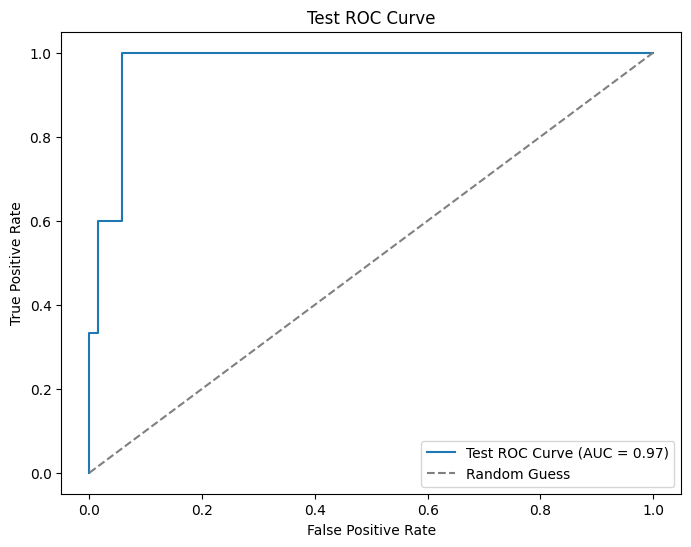

              precision    recall  f1-score   support

     Class 0       1.00      0.94      0.97        69
     Class 1       0.79      1.00      0.88        15

    accuracy                           0.95        84
   macro avg       0.89      0.97      0.93        84
weighted avg       0.96      0.95      0.95        84



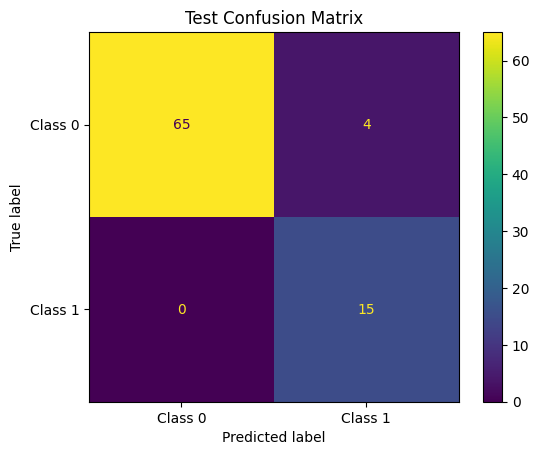

In [56]:
# Evaluate on test set
model.eval()
test_true_labels = []
test_predicted_probs = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images.unsqueeze(1))
        probs = torch.softmax(outputs, dim=1)[:, 1]  # Probability of the positive class
        test_true_labels.extend(labels.cpu().numpy())
        test_predicted_probs.extend(probs.cpu().numpy())

# Compute Metrics
from sklearn.metrics import roc_curve, auc, classification_report, confusion_matrix, ConfusionMatrixDisplay

# Compute ROC Curve and AUC
fpr, tpr, _ = roc_curve(test_true_labels, test_predicted_probs)
test_roc_auc = auc(fpr, tpr)

# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"Test ROC Curve (AUC = {test_roc_auc:.2f})")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Test ROC Curve')
plt.legend(loc='lower right')
plt.show()

# Classification Report
threshold = 0.5  # Default threshold for classification
test_predicted_labels = [1 if prob >= threshold else 0 for prob in test_predicted_probs]
print(classification_report(test_true_labels, test_predicted_labels, target_names=['Class 0', 'Class 1']))

# Confusion Matrix
cm = confusion_matrix(test_true_labels, test_predicted_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Class 0', 'Class 1'])
disp.plot(cmap='viridis')
plt.title('Test Confusion Matrix')
plt.show()
